# Core results

In [1]:
import collections
import numpy as np
import pickle
import torch
from tqdm import tqdm
import wandb

import sys
sys.path.append('../')
import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(font="Arial", style="ticks")

In [2]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/24041 [00:00<?, ?it/s]

Found 24041


100%|██████████| 24041/24041 [04:27<00:00, 89.99it/s]


Normalize names.

In [3]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
df.groupby(['dataset', 'subset_overall']).first()

,,key,family,subset,features,layer,features_layer,report_corr,max_r2,rnorm
dataset,subset_overall,,,,,,,,,
mst,36,I3D_layer00_mst_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.271957,0.961184,0.282940
mt1,84,I3D_layer00_mt1_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.035600,1.000000,0.035600
mt2,44,I3D_layer00_mt2_0,SlowFast,0,i3d,0,i3d_00,0.182025,1.000000,0.182025
pvc1,23,I3D_layer00_pvc1-repeats_0,SlowFast,0,i3d,0,i3d_00,0.150142,0.757951,0.198090
pvc4,25,I3D_layer00_pvc4_0,SlowFast,0,i3d,0,i3d_00,0.709660,1.000000,0.709660


# Key measurements table

In [4]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

models = ['slowfast', 'i3d', 'r3d_18', 'r2plus1d_18', 'mc3_18',  'cpc_ucf', 'cpc_airsim', 'gaborpyramid3d_motionless', 'gaborpyramid3d',  'motionnet', 'dorsalnet']
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets].loc[models]
df_s = df_s[datasets].loc[models]
df_z = df_z[datasets].loc[models]
    
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.replace('_', '\_')]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})"[1:])
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")
                
    the_str += ' & '.join(vals) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
slowfast & \textbf{0.471} (0.034) & .361 (0.042) & .211 (0.018) & .281 (0.015) & .189 (0.044)\\
i3d & \textbf{0.457} (0.036) & \textbf{0.389} (0.046) & .213 (0.018) & .284 (0.015) & .219 (0.044)\\
r3d\_18 & .403 (0.032) & \textbf{0.383} (0.042) & .217 (0.018) & .289 (0.015) & .224 (0.046)\\
r2plus1d\_18 & .428 (0.035) & \textbf{0.382} (0.042) & .215 (0.018) & .282 (0.015) & .226 (0.043)\\
mc3\_18 & .405 (0.034) & \textbf{0.393} (0.045) & .218 (0.018) & .276 (0.014) & .228 (0.045)\\
cpc\_ucf & .271 (0.044) & \textbf{0.394} (0.046) & .214 (0.018) & .241 (0.016) & .190 (0.045)\\
cpc\_airsim & .422 (0.036) & \textbf{0.384} (0.045) & \textbf{0.250} (0.020) & \textbf{0.360} (0.017) & .292 (0.045)\\
gaborpyramid3d\_motionless & .273 (0.035) & .353 (0.038) & .212 (0.018) & .188 (0.014) & .248 (0.045)\\
gaborpyramid3d & .325 (0.036) & \textbf{0.366} (0.037) & \textbf{0.249} (0.019) & .301 (0.015) & .394 (0.054)\\
m

In [5]:
import scipy.stats
zvals = pd.DataFrame(2*scipy.stats.norm.cdf(df_z))
zvals.columns = df_z.columns
zvals.index = df_z.index
zvals

dataset,pvc1,pvc4,mt1,mt2,mst
features,,,,,
slowfast,1.000000e+00,0.042839,2.092876e-11,3.588933e-09,9.902358e-14
i3d,3.908415e-01,0.790068,4.623430e-11,4.380028e-09,1.695351e-12
r3d_18,3.162239e-07,0.579303,3.132505e-11,5.201755e-09,2.163675e-12
r2plus1d_18,6.565309e-03,0.516364,9.367312e-11,1.222379e-09,3.641735e-13
mc3_18,1.487278e-05,0.940749,2.614022e-10,3.024382e-10,7.232839e-13
cpc_ucf,1.793635e-08,1.000000,4.396723e-11,3.700727e-18,6.510380e-17
cpc_airsim,3.991252e-02,0.531581,4.738280e-01,6.409934e-02,7.775257e-08
gaborpyramid3d_motionless,1.363588e-15,0.026132,5.692477e-13,2.063481e-28,9.144821e-16
gaborpyramid3d,3.454557e-11,0.143870,2.200543e-01,1.017647e-11,2.406699e-04


mst, cells better 13/36
mt1, cells better 42/84
mt2, cells better 29/44
pvc1, cells better 14/23
pvc4, cells better 11/25


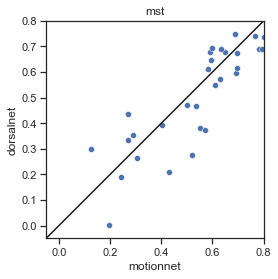

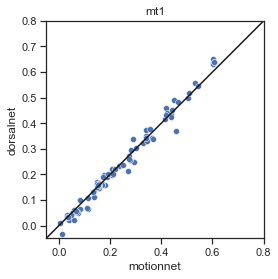

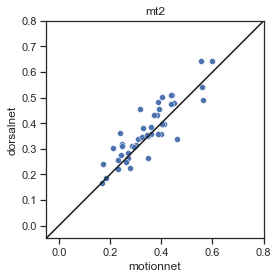

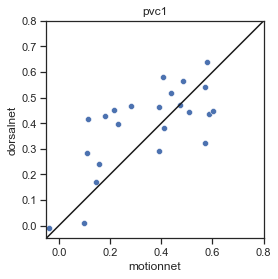

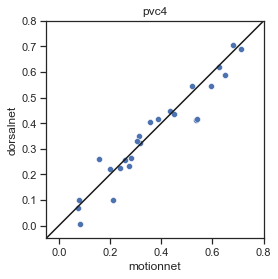

In [6]:
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    best_layer = df_m.idxmax(axis=1)

    good_combos = [f'{x}_{y:02}' for x, y in zip(best_layer.index, best_layer.values)]
    df_ = df_[df_.features_layer.isin(good_combos)]
    df_ = df_.pivot_table('rnorm', 'subset', 'features')
    plt.figure()
    g = sns.scatterplot(x='motionnet', y='dorsalnet', data=df_, ax=plt.gca())
    
    g.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    g.set_xlim([-.05, .8])
    g.set_ylim([-.05, .8])
    plt.title(dataset)
    
    nbetter = (df_.dorsalnet > df_.motionnet).sum()
    ntotal = df_.shape[0]
    print(f"{dataset}, cells better {nbetter}/{ntotal}")

# Bump plots
Calculate bump plots for alignment between area and layer across all relative scalings of the data

In [7]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'scale': round((sz / 112) * 100) / 100,
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer', 'scale']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer', 'scale'), right_on=('dataset', 'features', 'layer', 'scale'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]

  0%|          | 0/6119 [00:00<?, ?it/s]

Found 6119


100%|██████████| 6119/6119 [00:59<00:00, 103.64it/s]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


0.9993541666666667
0.1526630489359382
[0.70833333 1.         1.3125    ]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


1.9134141732283465
0.10142404335340381
[1.70866142 1.91338583 2.11023622]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.470184375
0.2683616256091943
[1.9375  2.46875 3.     ]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


1.1465395833333334
0.1695435953518339
[0.83333333 1.14583333 1.5       ]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.047996062992126
0.11161216089230117
[1.83464567 2.04724409 2.26771654]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.87568125
0.28317281046374754
[2.3125 2.875  3.4375]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


1.3179234042553192
0.19743016510924982
[0.95744681 1.31914894 1.72340426]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.0780897637795275
0.11278195967627475
[1.85826772 2.07874016 2.29133858]


<ipython-input-8-3444b50a2cf2>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.634276666666667
0.2523386153344131
[2.13333333 2.63333333 3.10083333]


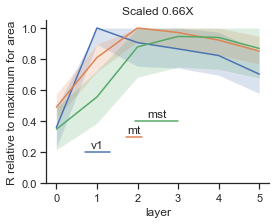

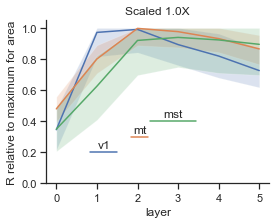

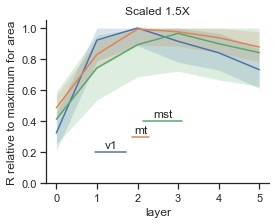

In [8]:

for ratio in [0.66, 1.0, 1.5]:
    def bs(df):
        df = df.copy()
        idx = np.random.randint(0, df.shape[0], df.shape[0])
        df_ = df.iloc[idx]
        the_max = df_.groupby(['area', 'layer']).rnorm.mean().groupby('area').max()
        df_ = df_.groupby(['area', 'layer']).rnorm.mean() / the_max
        return df_

    dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

    df['area'] = df.dataset.map(lambda x: dmap[x])
    df_ = df.query(f'features == "dorsalnet" and scale == {ratio}')
    df_ = df_.sort_values('area', ascending=True)

    df_['rnorm_max'] = df_.rnorm
    A = np.array([bs(df_).values for x in range(500)])
    df__ = pd.DataFrame(A.T)
    df__.index = bs(df_).index
    plt.figure(figsize=(4, 3))

    lines = []
    for area in ['v1', 'mt', 'mst']:
        vals = np.quantile(df__.loc[area], [.05, .95, .5], axis=1).T
        plt.fill_between(df__.loc[area].index, vals[:, 0], vals[:, 1], alpha=.2)
        lines.append(plt.plot(df__.loc[area].index, vals[:, 2]))
    sns.despine()
    plt.xlabel('layer')
    plt.ylabel('R relative to maximum for area')
    plt.yticks([0, .2, .4, .6, .8, 1.0])

    cols = sns.color_palette(as_cmap=True)
    for i, area in enumerate(['v1', 'mt', 'mst']):
        df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}" and scale == {ratio}')
        df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
        v = df_.pivot('dataset_subset', 'layer', 'rnorm').values

        vals = []
        for n in range(10000):
            v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
            #cs = CubicSpline(np.arange(6), v_)
            #xs = np.linspace(0, 5)
            vals.append(v_.mean())

        print(np.mean(vals))
        print(np.std(vals))

        q = np.quantile(vals, [.025, .975])
        plt.plot(q, (.2 + .1*i) * np.array([1, 1]), color=lines[i][0].get_color())
        plt.text((q[0] + q[1])/2, .225 + .1*i, area, {'ha': 'center'})
        print(np.quantile(vals, [.025, .5, .975]))

    plt.ylim([0, 1.05])
    plt.title(f'Scaled {ratio}X')
    
    #plt.savefig(f'/home/pmin/paper-assets/figure-2-layer-alignment-rescaled-{ratio}.pdf', bbox_inches='tight')
    #plt.savefig(f'/home/pmin/paper-assets/figure-2-layer-alignment-rescaled-{ratio}.png', bbox_inches='tight')

In [9]:
datasets = df.dataset.unique()

for ratio in [0.66, 1.0, 1.5]:
    perf = []
    for dataset in datasets:
        df_ = df.query(f'dataset == "{dataset}" and scale == {ratio}')
        df_m = df_.pivot_table('rnorm', 'features', 'layer')
        df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

        m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
        s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

        series = df_.groupby(['features_layer']).mean().report_corr
        best = series.index[series.argmax()]

        df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
        df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
        df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
        df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
        df_ = (df_m_delta / df_s_delta).max(axis=1)

        perf += [{'dataset': dataset, 
                  'features': f, 
                  'z': df_.loc[f],
                  'm': mm, 
                  's': ss} for f, mm, ss in zip(df_m.index, m, s)]

    df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
    df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
    df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

    models = ['motionnet', 'dorsalnet']
    datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

    df_m = df_m[datasets].loc[models]
    df_s = df_s[datasets].loc[models]
    df_z = df_z[datasets].loc[models]

    the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
    the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
    the_str += '\midrule \n'

    for idx, row in df_m.iterrows():
        vals = [idx.replace('_', '\_')]
        for feature, v in row.items():
            if np.isnan(v):
                vals.append('-')
            else:
                if df_z.loc[idx, feature].item() < -1.96:
                    vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
                else:
                    vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

        the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

    the_str += "\end{tabular}\n"
    print(the_str)

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
motionnet & .303 (.044) & \textbf{.373} (.041) & .221 (.018) & .306 (.016) & .403 (.052)\\
dorsalnet & \textbf{.358} (.041) & \textbf{.380} (.040) & \textbf{.245} (.018) & \textbf{.388} (.016) & \textbf{.460} (.056)\\
\end{tabular}

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
motionnet & .276 (.042) & \textbf{.364} (.039) & .238 (.018) & .333 (.016) & \textbf{.441} (.053)\\
dorsalnet & \textbf{.364} (.043) & \textbf{.370} (.039) & \textbf{.251} (.019) & \textbf{.381} (.017) & \textbf{.454} (.054)\\
\end{tabular}

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
motionnet & \textbf{.343} (.040) & \textbf{.371} (.039) & \textbf{.252} (.019) & .346 (.016) & \textbf{.452} (.050)\\
dorsalnet & \textbf{.389} (.034) & \textbf{.359} (.038) & \textbf{.252} (.020) & \textbf{.370} (.017) & \textbf{.411} (.052)\\
\end{tabular}



# Resizing, with regression

In [10]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/6119 [00:00<?, ?it/s]

Found 6119


100%|██████████| 6119/6119 [00:59<00:00, 102.51it/s]


In [11]:

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]

In [12]:
datasets = df.dataset.unique()
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

df_m = df_m[datasets]
df_s = df_s[datasets]
df_z = df_z[datasets]

In [13]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{lllllll}
\toprule 
{scaling} & {model} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & \textbf{.358} (.041) & \textbf{.380} (.040) & .245 (.018) & \textbf{.388} (.016) & \textbf{.460} (.056)\\
dorsalnet & 1.00 & \textbf{.364} (.043) & \textbf{.370} (.039) & \textbf{.251} (.019) & \textbf{.381} (.017) & \textbf{.454} (.054)\\
dorsalnet & 1.50 & \textbf{.389} (.034) & \textbf{.359} (.038) & \textbf{.252} (.020) & .370 (.017) & .411 (.052)\\
motionnet & .66 & .303 (.044) & \textbf{.373} (.041) & .221 (.018) & .306 (.016) & .403 (.052)\\
motionnet & 1.00 & .276 (.042) & \textbf{.364} (.039) & .238 (.018) & .333 (.016) & \textbf{.441} (.053)\\
motionnet & 1.50 & \textbf{.343} (.040) & \textbf{.371} (.039) & \textbf{.252} (.019) & .346 (.016) & \textbf{.452} (.050)\\
\end{tabular}



# Boosting results with resizing

In [14]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/4042 [00:00<?, ?it/s]

Found 4042


100%|██████████| 4042/4042 [00:33<00:00, 121.51it/s]


In [15]:


results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
#df.query('dataset == "mst"').groupby('features_layer').mean()
#df.query('features == "dorsalnet"')
nums

,dataset,features,layer,subset
0,mst,dorsalnet_0.66,0,36
1,mst,dorsalnet_0.66,1,36
2,mst,dorsalnet_0.66,2,36
3,mst,dorsalnet_0.66,3,36
4,mst,dorsalnet_0.66,4,36
5,mst,dorsalnet_0.66,5,36
6,mst,dorsalnet_1.00,0,36
7,mst,dorsalnet_1.00,1,36
8,mst,dorsalnet_1.00,2,36
9,mst,dorsalnet_1.00,3,36


In [16]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
datasets = ['mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

#models = ['motionnet', 'dorsalnet']
#datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets]#.loc[models]
df_s = df_s[datasets]#.loc[models]
df_z = df_z[datasets]#.loc[models]

In [17]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{lllll}
\toprule 
{scaling} & {model} & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & - & - & \textbf{.464} (.054)\\
dorsalnet & 1.00 & \textbf{.228} (.017) & \textbf{.370} (.016) & \textbf{.474} (.051)\\
dorsalnet & 1.50 & \textbf{.230} (.017) & .362 (.016) & .434 (.051)\\
motionnet & .66 & - & - & .336 (.050)\\
motionnet & 1.00 & .159 (.012) & .284 (.012) & .361 (.048)\\
motionnet & 1.50 & .160 (.011) & .298 (.012) & .385 (.047)\\
\end{tabular}



# Resizing, boosting with downsampling

In [18]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/4042 [00:00<?, ?it/s]

Found 4042


100%|██████████| 4042/4042 [00:32<00:00, 122.67it/s]


In [19]:
results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses no 
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
nums

,dataset,features,layer,subset
0,mst,dorsalnet_0.66,0,36
1,mst,dorsalnet_0.66,1,36
2,mst,dorsalnet_0.66,2,36
3,mst,dorsalnet_0.66,3,36
4,mst,dorsalnet_0.66,4,36
5,mst,dorsalnet_0.66,5,36
6,mst,dorsalnet_1.00,0,36
7,mst,dorsalnet_1.00,1,36
8,mst,dorsalnet_1.00,2,36
9,mst,dorsalnet_1.00,3,36


In [20]:
datasets = df.dataset.unique()
datasets = ['mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')


df_m = df_m[datasets]
df_s = df_s[datasets]
df_z = df_z[datasets]

In [21]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{lllll}
\toprule 
{scaling} & {model} & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & - & - & \textbf{.464} (.054)\\
dorsalnet & 1.00 & \textbf{.228} (.017) & \textbf{.370} (.016) & \textbf{.474} (.051)\\
dorsalnet & 1.50 & \textbf{.230} (.017) & .362 (.016) & .434 (.051)\\
motionnet & .66 & - & - & .336 (.050)\\
motionnet & 1.00 & .159 (.012) & .284 (.012) & .361 (.048)\\
motionnet & 1.50 & .160 (.011) & .298 (.012) & .385 (.047)\\
\end{tabular}



# Boosting results, subsampling

In [23]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample_t"},
                     {"config.method": "boosting"},
                     {"config.features": {"$in": ["airsim_04", "MotionNet"]}},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
            
    sz = 112
    if 'resize' in run.config:
        sz = run.config['resize']
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}_{sz}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/5084 [00:00<?, ?it/s]

Found 5084


100%|██████████| 5084/5084 [00:39<00:00, 128.49it/s]


In [24]:


results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
    
    if v['corrs_report'][0] is None:
        # This happens when boosting chooses nothing
        v['corrs_report'][0] = 0.0
        
    sz = 112
    if 'resize' in v['config']:
        sz = v['config']['resize']
    
    scale = f"{round((sz / 112) * 100) / 100:.2f}"
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': f"{friendly_name}_{scale}",
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{scale}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]

In [25]:
datasets = df.dataset.unique()
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']
df_ms = []
df_ss = []
df_zs = []

perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)

    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]

    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

df_m = df_m[datasets]
df_s = df_s[datasets]
df_z = df_z[datasets]

In [26]:
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 2)}}}\n\\toprule \n"
the_str += '{scaling} & {model} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.split('_')[0], idx.split('_')[1]]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})")
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")

    the_str += ' & '.join([x.replace('0.', '.') for x in vals]) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{lllllll}
\toprule 
{scaling} & {model} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
dorsalnet & .66 & .471 (.051) & \textbf{.355} (.038) & .212 (.016) & \textbf{.353} (.016) & \textbf{.435} (.052)\\
dorsalnet & 1.00 & \textbf{.491} (.049) & .313 (.039) & \textbf{.217} (.016) & \textbf{.348} (.016) & \textbf{.415} (.055)\\
dorsalnet & 1.50 & \textbf{.503} (.051) & \textbf{.313} (.034) & .209 (.016) & .328 (.016) & .356 (.052)\\
motionnet & .66 & .371 (.048) & \textbf{.319} (.036) & .157 (.012) & .258 (.013) & .345 (.049)\\
motionnet & 1.00 & .426 (.050) & \textbf{.311} (.034) & .158 (.012) & .271 (.012) & .359 (.048)\\
motionnet & 1.50 & \textbf{.460} (.051) & .313 (.036) & .158 (.012) & .282 (.012) & .365 (.047)\\
\end{tabular}



# Present CKA results

(0.0, 6.0)

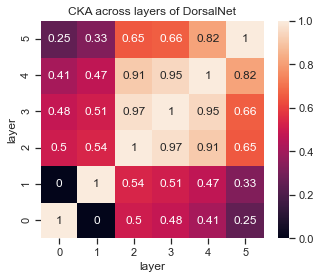

In [27]:
A = np.load('../cka.npy')
plt.figure(figsize=(5, 4))
f = sns.heatmap(A[:-1, :-1], annot=True)
plt.xlabel('layer')
plt.ylabel('layer')
plt.title('CKA across layers of DorsalNet')
plt.ylim([0, 6])
#plt.savefig('../revision/cka.pdf')